In [1]:
import os 
import time
import re
import pandas as pd 
import spacy
from datetime import date

import requests
from bs4 import BeautifulSoup

import matplotlib.pyplot as plt

from selenium import webdriver
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.common.by import By
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.firefox.options import Options
#from selenium.webdriver.common.keys import Keys

nlp = spacy.load('en_core_web_sm', disable=['parser', 'lemmatizer', 'tagger'])

# if i scrape NPR The head needs to be on 

In [25]:
def start_selenium(source, url):
    options = Options()
    #options.headless = True
    driver = webdriver.Firefox(executable_path='/home/stephbuon/projects/entascope/geckodriver', options=options)
    driver.get(url)

    if source == 'FOX':
        #search_archive(driver)
        
        #WebDriverWait(driver, 1).until(EC.element_to_be_clickable((By.CSS_SELECTOR, '.load-more > a:nth-child(1)'))).click() # get rid of this for media -- or maybe i Have no need at all 
        for i in range(100):
            try:
                driver.find_element(By.CSS_SELECTOR, '.pf-widget-close').click()
            except:
                pass

            try:
                driver.execute_script("arguments[0].scrollIntoView();", WebDriverWait(driver, 1).until(EC.visibility_of_element_located((By.CSS_SELECTOR, '.load-more > a:nth-child(1)'))))
                WebDriverWait(driver, 1).until(EC.element_to_be_clickable((By.CSS_SELECTOR, '.load-more > a:nth-child(1)'))).click()
            except Exception as e2: 
                print(e2)
                print('click number ' + str(i))
                pass

    if source == 'NPR':
        scroll_number = 350 #250
        for i in range(1, scroll_number):
            driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
            time.sleep(1)

            try:
                driver.find_element(By.CSS_SELECTOR, '.global-modal__dismiss').click()
            except:
                pass
    
    return driver.page_source


def validate_url(url, page_url, source):
    if source == 'FOX':
        if not 'https' in page_url:
            if '/politics/' in page_url or '/media/' in page_url or '/us/':
                page_url = 'https://www.foxnews.com' + page_url            # make sure there are no doubles 
                try:
                    return requests.get(page_url)
                except Exception as e3:
                    print(e3)
                    return None
                    
        elif 'q=coronavirus' in url:
            return requests.get(page_url)
    else:
        return requests.get(page_url)


def correct_entity_labels(named_entites):
    # d- and r- are recategorized to represent democrat or republican

    coronavirus = re.compile(r'covid|coronavirus|vaccine|omicron|delta|vaccinat|vaxx|pandemic|mask|\bncov\b', re.IGNORECASE)
    events = re.compile(r'twitter .*', re.IGNORECASE)
    vaccines = re.compile(r'pfizer|moderna', re.IGNORECASE)
    people = re.compile(r'warren|trump|psaki|palin|fauci', re.IGNORECASE)
    organizations = re.compile(r'd-.*|r-.*|england patriots|coronavirus task|covid.*response team|coronavirus.*response team|scarlet knights|astros', re.IGNORECASE) 
    locations = re.compile(r'eswatini', re.IGNORECASE)

    for index, row in named_entites.iterrows():
        row['entity_label'] = 'EVENT' if (re.match(coronavirus, row['entity_text'])) else row['entity_label']
        row['entity_label'] = 'EVENT' if (re.match(events, row['entity_text'])) else row['entity_label']
        row['entity_label'] = 'ORG' if (re.match(vaccines, row['entity_text'])) else row['entity_label']
        row['entity_label'] = 'PERSON' if (re.match(people, row['entity_text'])) else row['entity_label']
        row['entity_label'] = 'GPE' if (re.match(organizations, row['entity_text'])) else row['entity_label']
        row['entity_label'] = 'GPE' if (re.match(locations, row['entity_text'])) else row['entity_label']
    
    return named_entites


def export_data(export_path, scraped_pages, out, source, ts):

    if not os.path.exists(export_path + ts):
        os.mkdir(export_path + ts)

    citations = pd.DataFrame(
    {'url': scraped_pages.keys(), 'source': scraped_pages.values()} )

    clean_stuff = pd.DataFrame(citations['source'].tolist(), columns=['source', 'article_id'])

    del(citations['source'])
    citations = pd.concat([citations, clean_stuff], axis=1)

    if not os.path.isfile(export_path + ts + '/' + 'citations_' + source + '_' + ts + '.csv'):
        citations.to_csv(export_path + ts + '/' + 'citations_' + source + '_' + ts + '.csv', index = False)
    else:
        old_citations = pd.read_csv(export_path + ts + '/' + 'citations_' + source + '_' + ts + '.csv')
        citations = pd.concat([citations, old_citations], ignore_index = True)

        citations.to_csv(export_path + ts + '/' + 'citations_' + source + '_' + ts + '.csv', index = False)

    named_entites = pd.DataFrame(
        {'entity_label': out.keys(), 'entity_text': out.values() } )
            
    named_entites = named_entites.explode('entity_text')
    named_entites = correct_entity_labels(named_entites)

    if not os.path.isfile(export_path + ts + '/' + 'named_entities_' + source + '_' + ts + '.csv'):
        named_entites.to_csv(export_path + ts + '/' + 'named_entities_' + source + '_' + ts + '.csv')
    else:
        old_named_entities = pd.read_csv(export_path + ts + '/' + 'named_entities_' + source + '_' + ts + '.csv')
        named_entites = pd.concat([named_entites, old_named_entities], ignore_index = True)

        named_entites.to_csv(export_path + ts + '/' + 'named_entities_' + source + '_' + ts + '.csv', index = False)
    


def show_entity_labels():
    print("""
    PERSON:        People's names
    NORP:          Nationalities or religiouse or political groups.
    FAC:           Infrastructure such as buildings, airports, highways, bridges, etc.
    ORG:           Companies, agencies, institutions, etc.
    GPE:           Countries, cities, states.
    LOC:           Non-GPE locations, mountain ranges, bodies of water. 
    PRODUCT:       Objects, vehicles, foods, etc. (Not services.)
    EVENT:         Names of events. Natural disasters, battles, sports events, etc. Coronavirus strains like "omicron" are categorized as events.
    WORK_OF_ART:   Titles of books, songs, etc.
    LAW:           Names of documents made into laws.
    LANGUAGE:      Named languages.
    DATE:          Absolute or relative dates or periods.
    TIME:          Times smaller than a day.
    PERCENT:       Percentage, including "%".
    MONEY:         Monetary values.
    QUANTITY:      Measurements, as of weight or distance.
    ORDINAL:       Terms denoting order, such as "first" or "second."
    CARDINAL:      Numerals that do not fall under another time. 
    """)


def clean_entities(ls):
    ls = [str(word) for word in ls]

    ls = [word.lower() for word in ls]
    
    ls = [re.sub(r'^the ', '', word) for word in ls]
    ls = [re.sub(r'\'s', '', word) for word in ls]
    ls = [re.sub(r's\'', 's', word) for word in ls]
    ls = [re.sub(r'\`s', '', word) for word in ls]
    ls = [re.sub(r's\`', '', word) for word in ls]

    ls = [re.sub(r'covid.*19', 'covid-19', word) for word in ls]
    ls = [re.sub(r'covid.*19 -', 'covid-19', word) for word in ls]

    remove_image_credits = ['photo', 'getty', 'flickr']
    ls = [sa for sa in ls if not any(sb in sa for sb in remove_image_credits)]

    remove_news_outlets = re.compile(r'fox|abc|associated press|reuters|cnn|\bap\b|npr|nbc')
    # re.match matches the start of the string, while re.search looks for the pattern at any point in the string
    ls = [sa for sa in ls if not re.search(remove_news_outlets, sa)]
    
    return ls


def count_words(clean_data):
    ngrams_dict = {}
    for ngram in clean_data:
        if ngram in ngrams_dict:
            ngrams_dict[ngram] += 1
        else:
            ngrams_dict[ngram] = 1
    
    return ngrams_dict


def time_stamp():
    today = date.today()
    d_today = today.strftime("%m-%d-%Y")

    return d_today


def barplot_entities(df, ts, filter, source):
    df = df[df['entity_label'] == filter]
    df = df['entity_text'].tolist()
    df = clean_entities(df)
    df = count_words(df)
    df = pd.DataFrame(
    {'word': df.keys(), 'count': df.values() } )
    
    df = df[:80].copy()
    df.sort_values(by = ['count'], inplace = True, ascending = True)

    plt.barh(df['word'], df['count'])
    plt.ylabel(filter + ' Name')
    plt.title('Top ' + filter + 's Mentioned in ' + source + ' News Articles about Covid-19' )

    plt.rcParams["figure.figsize"] = [10,20]

    plt.savefig('/home/stephbuon/projects/entascope/scraped_pages/' + ts + '/' + source + '_' + filter + '.pdf')
    plt.show()
    plt.close()


def scraper(url, response, source, ts, **kwargs):

    #kw = kwargs.get('existing_set', None)

    keyword = re.compile(r'covid|coronavirus|vaccine|omicron|delta|vaccinat|vaxx|pandemic|mask', re.IGNORECASE)

    start_page = BeautifulSoup(response, 'html.parser')

    recorded_sites = {}
    
    #if kw is not None:
    if kwargs.get('existing_set') == True:
        scraped_pages_df = pd.read_csv('/home/stephbuon/projects/entascope/scraped_pages/' + ts + '/' + 'citations_' + source + '_' + ts + '.csv')
        scraped_pages_df['url'] = scraped_pages_df['url'].apply(lambda x: x.split('/')[-1])

        scraped_pages = dict(zip(scraped_pages_df['url'], scraped_pages_df['source']))
        
        max_no = scraped_pages_df['article_id'].max()

    else:
        scraped_pages = {}
        max_no = None

    out = {}

    article = 0
    cycle = 0
    for link in start_page.findAll('a'):

        if 'href' in str(link):
            page_url = link['href']

            if keyword.search(page_url):

                if not page_url.split('/')[-1] in scraped_pages.keys():

                    cycle = cycle + 1
                    if max_no is not None:
                        if cycle == 1:
                            article = max_no + 1
                        else:
                            article = article + 1
                    else:
                        article = article + 1

                    if source == 'FOX':
                        if not 'q=coronavirus' in url:
                            if '/politics/' in page_url or '/media/' in page_url or '/us/': 
                                if not 'https' in page_url: 
                                    record = 'https://www.foxnews.com' + page_url  
                                    recorded_sites[record] = [source, article] 
                        else: 
                            recorded_sites[page_url] = [source, article]
                    else: 
                        recorded_sites[page_url] = [source, article]

                    scraped_pages[page_url] = source
                    
                
                    next_page = validate_url(url, page_url, source) 
                    

                    #next_page = requests.get(page_url)
                    if next_page is not None:
                        try:
                            page_content = BeautifulSoup(next_page.text, 'html.parser')

                            # for every paragraph in the page content (denoted by the "p" anchor)
                            for paragraph in page_content.findAll('p'):
                                paragraph = list(paragraph.stripped_strings)

                                try: # Text of length 3072322 exceeds maximum of 1000000
                                    for sentence in paragraph: 
                                        sentence = nlp(sentence)

                                        for entity in sentence.ents:
                                            if not entity.label_ in out.keys():
                                                out[entity.label_] = [entity.text]
                                            else:
                                                out[entity.label_].append(entity.text)
                                except Exception as e2: 
                                    print(e2)
                                    print(page_url)
                        except Exception as e5:
                            print(e5)

                                
                                            
                    time.sleep(1)
 
   
        else:
            pass

    #start_page.quit() # will this turn off driver?
    export_data('/home/stephbuon/projects/entascope/scraped_pages/', recorded_sites, out, source, ts)


def scrape_pages_load_more(url, source, ts, **kwargs):

    existing_set = kwargs.get('existing_set', None)
    
    # selenium is used to activate triggers like "show more" buttons
    # the triggered website is then assigned to response (instead of using requests)
    response = start_selenium(source, url)
    #response = requests.get(url)

    scraper(url, response, source, ts, existing_set = existing_set)


def scrape_pages_multi_page(url, source, ts):

    keyword = re.compile(r'covid|coronavirus|vaccine|omicron|delta|vaccinat|vaxx|pandemic|mask', re.IGNORECASE)
    
    options = Options()
    #options.headless = True
    driver = webdriver.Firefox(executable_path='/home/stephbuon/projects/entascope/geckodriver', options=options)

    for i in range(5): 
        if source == 'KRISTV':
            url_w_page = url + str(i)

            driver.get(url_w_page)
            
            try:
                try:
                    driver.find_element(By.CSS_SELECTOR, '.MAD_INVIEW_CLOSE').click()
                except:
                    pass

                driver.execute_script("arguments[0].scrollIntoView();", WebDriverWait(driver, .5).until(EC.visibility_of_element_located((By.CSS_SELECTOR, "a.List"))))
                WebDriverWait(driver, .5).until(EC.element_to_be_clickable((By.CSS_SELECTOR, "a.List"))).click()

                scraper(driver.page_source, source, ts)
                
            except Exception as e: 
                print(e)
                pass  

In [13]:
from selenium.webdriver.support.ui import Select

def search_archive(driver):

    select = Select(driver.find_element(By.CSS_SELECTOR, 'div.month:nth-child(2) > ul:nth-child(2)'))
    
    select.select_by_value('1')

In [26]:
ts = time_stamp()
scrape_pages_load_more('https://www.npr.org/sections/news/archive', 'NPR', ts)#, existing_set = True)

# the scroll page for msbnc: https://www.msnbc.com/opinion/columnists

#https://www.npr.org/sections/news/archive 

#https://www.foxnews.com/media # do the hash out 
#https://www.foxnews.com/category/us/economy

# NPR August 9th at 350 scrolls 

# https://www.foxnews.com/lifestyle
# Dec 27 -- evening
# August 3rd
# 220 clicks
# ~10 minutes 

# https://www.foxnews.com/us
# Dec 27 -- evening
# August 3rd
# 400 clicks 
# ~30 minutes 

# https://www.foxnews.com/opinion 
# Dec 27 -- noon
# August 3rd
# 92 clicks
# ~9 minutes

# https://www.foxnews.com/politics
# Dec 27 -- noon 
# August 3rd 
# 400 clicks
# ~43 minutes

/tmp/ipykernel_5160/1715002918.py:4: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Firefox(executable_path='/home/stephbuon/projects/entascope/geckodriver', options=options)


[E088] Text of length 4485247 exceeds maximum of 1000000. The parser and NER models require roughly 1GB of temporary memory per 100,000 characters in the input. This means long texts may cause memory allocation errors. If you're not using the parser or NER, it's probably safe to increase the `nlp.max_length` limit. The limit is in number of characters, so you can check whether your inputs are too long by checking `len(text)`.
https://ondemand.npr.org/anon.npr-mp3/npr/wesun/2021/12/20211219_wesun_as_omicron_spreads_outgoing_nih_director_says_the_us_could_hit_1m_daily_cases.mp3?orgId=1&topicId=1128&aggIds=812054919&d=335&p=10&story=1065575540&dl=1&sc=siteplayer&size=5368312&dl=1&aw_0_1st.playerid=siteplayer
[E088] Text of length 12117033 exceeds maximum of 1000000. The parser and NER models require roughly 1GB of temporary memory per 100,000 characters in the input. This means long texts may cause memory allocation errors. If you're not using the parser or NER, it's probably safe to incr

/home/stephbuon/miniconda/lib/python3.8/site-packages/bs4/builder/_htmlparser.py:102: UserWarning: expected name token at '<![^+���d�\x003�I�q�\x1b`5'
  warnings.warn(msg)


TypeError: cannot unpack non-iterable NoneType object

In [ ]:
#def log_urls(source, url):
#    if source == 'FOX':
#        if 'q=coronavirus' in url:
#            pass
#        elif 

In [ ]:
import plotly.graph_objects as go

fig = go.Figure(go.Bar(
            x=[20, 14, 23],
            y=['giraffes', 'orangutans', 'monkeys'],
            orientation='h'))

fig.show()

In [20]:
ts = time_stamp()
scrape_pages_multi_page('https://www.kristv.com/?00000169-7dca-d05d-ab6f-7fdbf8990001-page=', 'KRISTV', ts)
# its not under us, its under politics 
#scrape_pages('https://www.foxnews.com/politics', 'FOX', ts)

/tmp/ipykernel_5094/1445053184.py:298: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Firefox(executable_path='/home/stephbuon/projects/entascope/geckodriver', options=options)


Message: Browsing context has been discarded
Stacktrace:
WebDriverError@chrome://marionette/content/error.js:181:5
NoSuchWindowError@chrome://marionette/content/error.js:415:5
assert.that/<@chrome://marionette/content/assert.js:460:13
assert.open@chrome://marionette/content/assert.js:168:4
GeckoDriver.prototype.findElement@chrome://marionette/content/driver.js:1615:10
despatch@chrome://marionette/content/server.js:291:40
execute@chrome://marionette/content/server.js:264:16
onPacket/<@chrome://marionette/content/server.js:237:20
onPacket@chrome://marionette/content/server.js:238:9
_onJSONObjectReady/<@chrome://marionette/content/transport.js:504:20



WebDriverException: Message: Failed to decode response from marionette


In [62]:
ts = time_stamp()
fox_ne = pd.read_csv('/home/stephbuon/projects/entascope/scraped_pages/' + ts + '/' + 'named_entities_FOX_' + ts +'.csv')
#msnbc_ne = pd.read_csv('/home/stephbuon/projects/entascope/scraped_pages/' + ts + '/' + 'named_entities_MSNBC_' + ts +'.csv')
#npr_ne = pd.read_csv('/home/stephbuon/projects/entascope/scraped_pages/' + ts + '/' + 'named_entities_NPR_' + ts +'.csv')

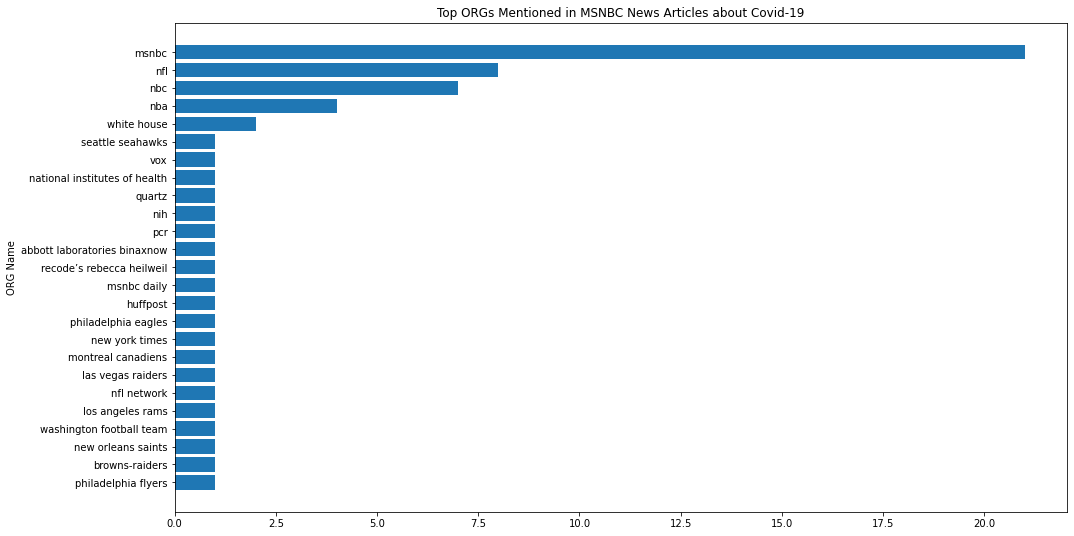

In [23]:
barplot_entities(msnbc_ne, ts, 'ORG', 'MSNBC') # cut off the 's 

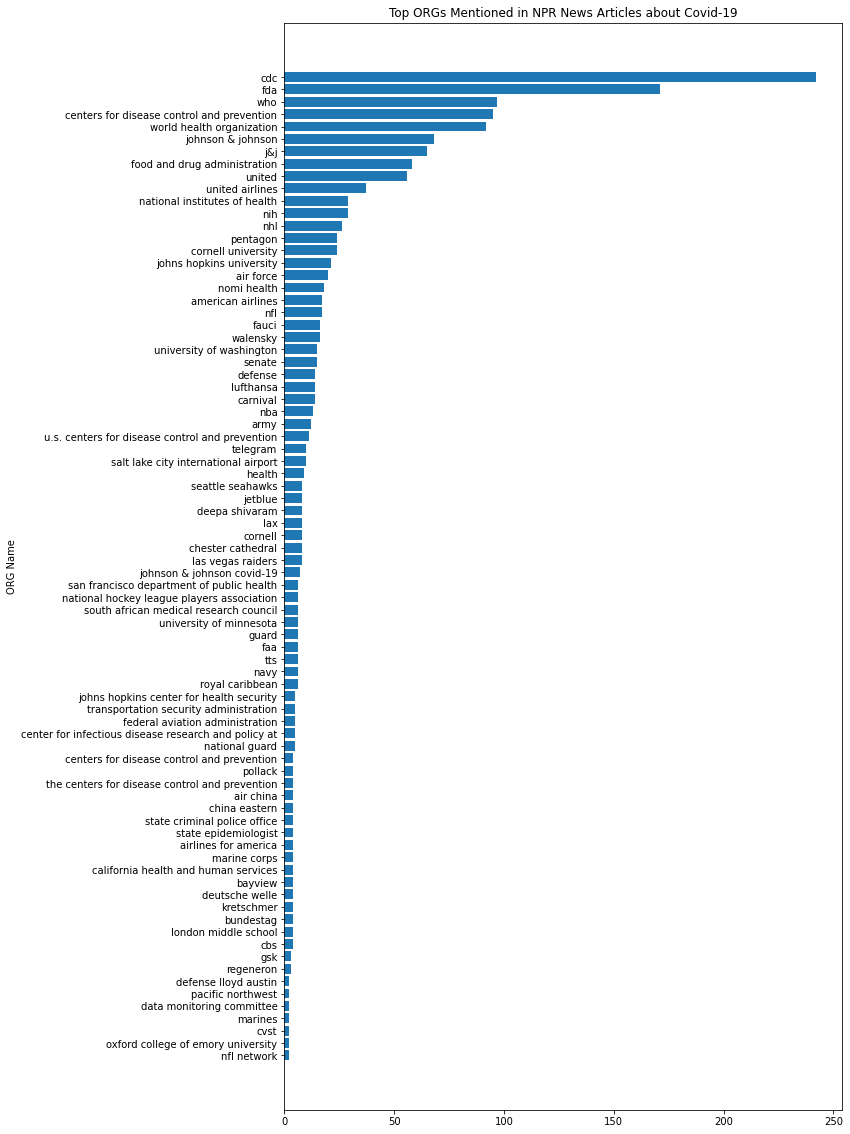

In [8]:
npr_ne = pd.read_csv('/home/stephbuon/projects/entascope/scraped_pages/' + ts + '/' + 'named_entities_NPR_' + ts +'.csv')
barplot_entities(npr_ne, ts, 'ORG', 'NPR') # cut off the 's 

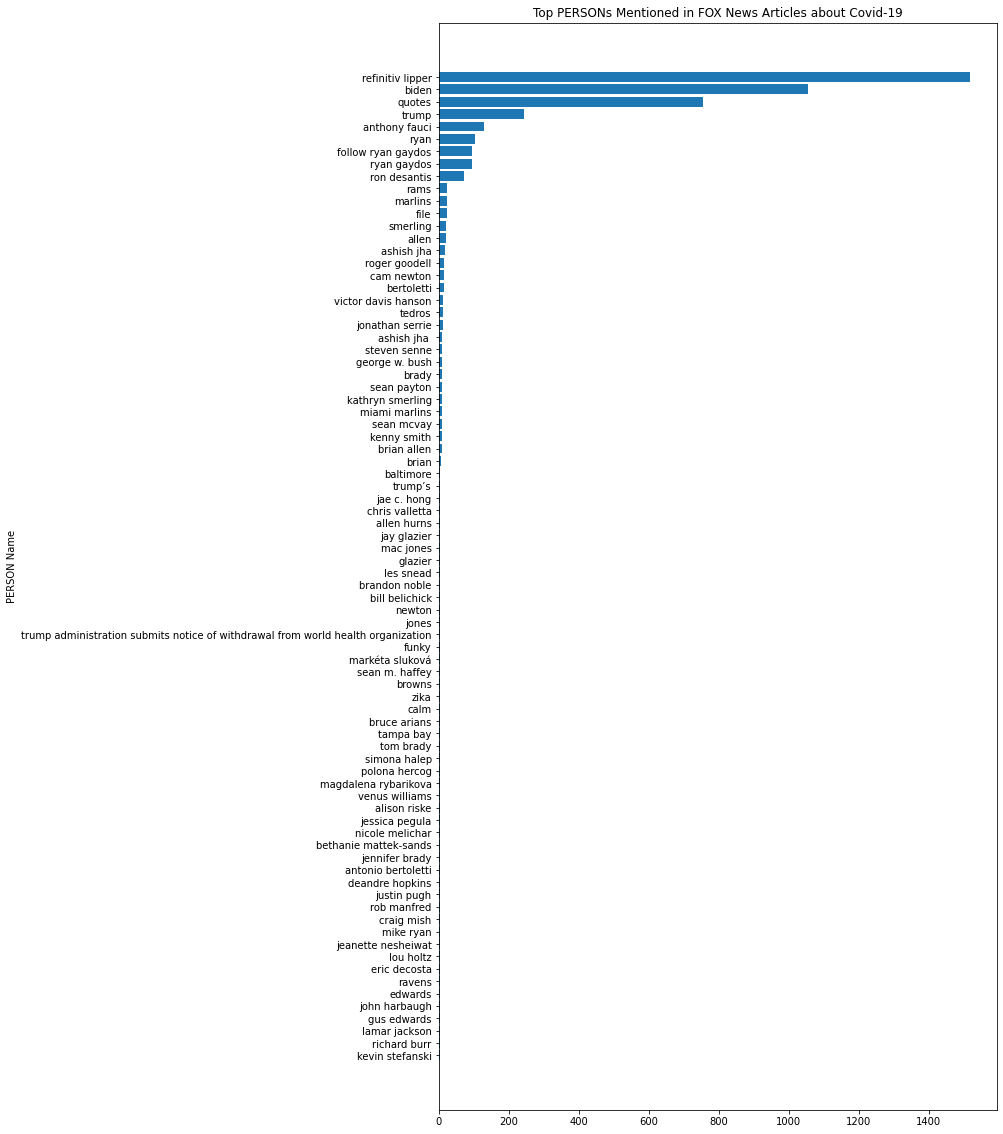

In [32]:
entities = ['EVENT', 'LAW', 'ORG']
fox_ne = pd.read_csv('/home/stephbuon/projects/entascope/scraped_pages/' + ts + '/' + 'named_entities_FOX_' + ts +'.csv')

#for entity in entities:
barplot_entities(fox_ne, ts, 'PERSON', 'FOX')

In [42]:
barplot_entities(fox_ne, 'PRODUCT', 'FOX')

TypeError: barplot_entities() missing 1 required positional argument: 'source'

In [ ]:
urls = ['https://www.npr.org/sections/news/', 'https://www.msnbc.com/', 'https://www.foxnews.com/']
sources = ['NPR', 'MSNBC', 'FOX']
ts = time_stamp()

#for url in urls:
#    for source in sources:
        #scrape_pages(url, source, ts)

scrape_pages('https://www.npr.org/sections/news/', 'NPR', ts)
scrape_pages('https://www.msnbc.com/', 'MSNBC', ts)
scrape_pages('https://www.foxnews.com/', 'FOX', ts)

In [14]:
# i want NORP 
# i want LOC
# GPE
# PERSON
# EVENT 
# ORG